In [1]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt
import numpy as np

In [2]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

maxcapacityfor_spp = 90
maxcapacityfor_vspp = 10

radius_spp_wind = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_wind * 3.14)) / 105,5)
radius_vspp_wind = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_wind * 3.14)) / 105,5)

radius_spp_solar = np.round(np.sqrt(maxcapacityfor_spp/(mwperkm2_solar * 3.14)) / 105,5)
radius_vspp_solar = np.round(np.sqrt(maxcapacityfor_vspp/(mwperkm2_solar * 3.14)) / 105,5)

print('radius_spp_wind km = ',radius_spp_wind*100,' buffer = ',radius_spp_wind)
print('radius_vspp_wind km = ',radius_vspp_wind*100,' buffer = ',radius_vspp_wind)
print('radius_spp_solar km = ',radius_spp_solar*100,' buffer = ',radius_spp_solar)
print('radius_vspp_solar km = ',radius_vspp_solar*100,' buffer = ',radius_vspp_solar)

radius_spp_wind km =  2.404  buffer =  0.02404
radius_vspp_wind km =  0.8009999999999999  buffer =  0.00801
radius_spp_solar km =  1.317  buffer =  0.01317
radius_vspp_solar km =  0.439  buffer =  0.00439


In [3]:
xr_out = xr.open_dataset('Output\\xr_output.nc')
print(xr_out)
print("cap_SPP_wind = ",xr_out['cap_SPP_wind'].sum())
print("cap_VSPP_wind = ",xr_out['cap_VSPP_wind'].sum())
print("cap_SPP_solar = ",xr_out['cap_SPP_solar'].sum())
print("cap_VSPP_solar = ",xr_out['cap_VSPP_solar'].sum())
print(xr_out['ADM1_EN'].where(xr_out['ADM1_EN']=='R0',1,0).count())

<xarray.Dataset>
Dimensions:         (lat: 1069, lon: 597)
Coordinates:
  * lat             (lat) float64 5.621 5.635 5.649 5.663 ... 20.43 20.44 20.45
  * lon             (lon) float64 97.35 97.37 97.38 97.39 ... 105.6 105.6 105.6
Data variables: (12/14)
    SI_Solar        (lat, lon) float64 ...
    SI_Wind         (lat, lon) float64 ...
    AVA_Wind        (lat, lon) float32 ...
    AVA_Solar       (lat, lon) float32 ...
    SI_Wind_max     (lat, lon) float64 ...
    SI_Wind_min     (lat, lon) float64 ...
    ...              ...
    ADM1_EN         (lat, lon) object ...
    region          (lat, lon) object ...
    cap_SPP_wind    (lat, lon) float64 ...
    cap_VSPP_wind   (lat, lon) float64 ...
    cap_SPP_solar   (lat, lon) float64 ...
    cap_VSPP_solar  (lat, lon) float64 ...
cap_SPP_wind =  <xarray.DataArray 'cap_SPP_wind' ()>
array(7352.37013245)
cap_VSPP_wind =  <xarray.DataArray 'cap_VSPP_wind' ()>
array(26174.74565018)
cap_SPP_solar =  <xarray.DataArray 'cap_SPP_solar' ()>

In [4]:
df_wind = xr_out.to_dataframe()
df_wind.reset_index(inplace=True)
df_wind = gpd.GeoDataFrame(df_wind, geometry =gpd.points_from_xy(df_wind['lon'],df_wind['lat']))
df_wind.crs = {'init': 'epsg:4326'}
print(len(df_wind))
for i,c in enumerate(df_wind.columns):
    if c not in (['lon','lat','SI_Wind','SI_Wind_max','SI_Wind_min','region','ADM1_EN','cap_SPP_wind','cap_VSPP_wind','AVA_Wind','geometry']):
        df_wind = df_wind.drop(columns=c)

df_wind_spp = df_wind.drop(columns='cap_VSPP_wind')
df_wind_spp = df_wind_spp.loc[df_wind_spp['cap_SPP_wind'] > 0]
df_wind_spp.reset_index(inplace=True,drop=False)
df_wind_spp.crs = {'init': 'epsg:4326'}
df_wind_spp['buffer'] = df_wind_spp['geometry'].buffer(radius_spp_wind,cap_style = 3)
df_wind_spp = df_wind_spp.set_geometry('buffer')

df_wind_spp['no_spp_wind'] = np.ceil(df_wind_spp['cap_SPP_wind']/maxcapacityfor_spp)
df_wind_spp_normal = df_wind_spp.loc[df_wind_spp['no_spp_wind'] == 1]
df_wind_spp_clustered = df_wind_spp.loc[df_wind_spp['no_spp_wind'] > 1]

df_wind_vspp = df_wind.drop(columns='cap_SPP_wind')
df_wind_vspp = df_wind_vspp.loc[df_wind_vspp['cap_VSPP_wind'] > 0]
df_wind_vspp.reset_index(inplace=True,drop=False)
df_wind_vspp.crs = {'init': 'epsg:4326'}
df_wind_vspp['buffer'] = df_wind_vspp['geometry'].buffer(radius_vspp_wind,cap_style = 3)
df_wind_vspp = df_wind_vspp.set_geometry('buffer')

df_wind_spp.to_csv('Output\\Output_wind_spp.csv',index=False,encoding="utf-8-sig")
df_wind_vspp.to_csv('Output\\Output_wind_vspp.csv',index=False,encoding="utf-8-sig")

print(df_wind_spp)
print(df_wind_vspp)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638193


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_16628\1522938015.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_wind_spp['buffer'] = df_wind_spp['geometry'].buffer(radius_spp_wind,cap_style = 3)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change,

      index        lat         lon   SI_Wind  AVA_Wind  SI_Wind_max  \
0    104057   8.037500   99.837500  2.353395      2.25     2.358509   
1    105225   8.065278   99.476389  2.193806      2.25     2.195327   
2    108212   8.134722   99.504167  2.084839      2.25     2.086056   
3    113578   8.259722   99.406944  2.080055      2.25     2.151628   
4    121321   8.440278   99.156944  2.000380      2.25     2.007715   
..      ...        ...         ...       ...       ...          ...   
198  538320  18.134722  103.226389  1.895768      2.25     1.912042   
199  539547  18.162500  103.684722  0.150888      0.27     1.257710   
200  540127  18.176389  103.448611  1.978730      2.25     1.980414   
201  540721  18.190278  103.406944  1.972838      2.25     1.974472   
202  543719  18.259722  103.587500  0.193732      0.36     1.252455   

     SI_Wind_min              ADM1_EN region  cap_SPP_wind  \
0       2.264598  Nakhon Si Thammarat     R3        91.125   
1       2.192289  Nakho

In [5]:
df_solar = xr_out.to_dataframe()
df_solar.reset_index(inplace=True)
df_solar = gpd.GeoDataFrame(df_solar, geometry =gpd.points_from_xy(df_solar['lon'],df_solar['lat']))
df_solar.crs = {'init': 'epsg:4326'}
print(len(df_solar))
for i,c in enumerate(df_solar.columns):
    if c not in (['lon','lat','SI_Solar','SI_Solar_max','SI_Solar_min','region','ADM1_EN','cap_SPP_solar','cap_VSPP_solar','AVA_Solar','geometry']):
        df_solar = df_solar.drop(columns=c)

df_solar_spp = df_solar.drop(columns='cap_VSPP_solar')
df_solar_spp = df_solar_spp.loc[df_solar_spp['cap_SPP_solar'] > 0]
df_solar_spp.reset_index(inplace=True,drop=False)
df_solar_spp.crs = {'init': 'epsg:4326'}
df_solar_spp['buffer'] = df_solar_spp['geometry'].buffer(radius_spp_solar,cap_style = 3)
df_solar_spp = df_solar_spp.set_geometry('buffer')

df_solar_vspp = df_solar.drop(columns='cap_SPP_solar')
df_solar_vspp = df_solar_vspp.loc[df_solar_vspp['cap_VSPP_solar'] > 0]
df_solar_vspp.reset_index(inplace=True,drop=False)
df_solar_vspp.crs = {'init': 'epsg:4326'}
df_solar_vspp['buffer'] = df_solar_vspp['geometry'].buffer(radius_vspp_solar,cap_style = 3)
df_solar_vspp = df_solar_vspp.set_geometry('buffer')


df_solar_spp.to_csv('Output\\Output_solar_spp.csv',index=False,encoding="utf-8-sig")
df_solar_vspp.to_csv('Output\\Output_solar_vspp.csv',index=False,encoding="utf-8-sig")

print(df_solar_spp)
print(df_solar_vspp)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


638193


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_16628\507924514.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_solar_spp['buffer'] = df_solar_spp['geometry'].buffer(radius_spp_solar,cap_style = 3)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the chang

     index        lat         lon  SI_Solar  AVA_Solar  SI_Solar_max  \
0    67661   7.190278  100.129167  2.353603       2.25      2.407850   
1    71865   7.287500  100.476389  2.678810       2.25      2.680579   
2    88514   7.676389   99.545833  2.260387       2.25      2.334430   
3    99909   7.940278  100.268056  2.568998       2.25      2.570823   
4   107066   8.106944  100.170833  2.597983       2.25      2.599883   
..     ...        ...         ...       ...        ...           ...   
93  508996  17.454167  102.240278  2.111398       2.25      2.220776   
94  511300  17.509722  101.073611  0.656811       0.72      2.205870   
95  519822  17.704167  103.351389  2.224457       2.25      2.332998   
96  526386  17.856944  103.309722  2.197189       2.25      2.320779   
97  544299  18.273611  103.351389  2.070796       2.25      2.154197   

    SI_Solar_min              ADM1_EN region  cap_SPP_solar  \
0       2.167072          Phatthalung     R3     299.699982   
1       2

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


total wind capacity =  33527.11578262133
total SPP wind capacity =  7352.370132446101
total VSPP wind capacity =  26174.74565017523


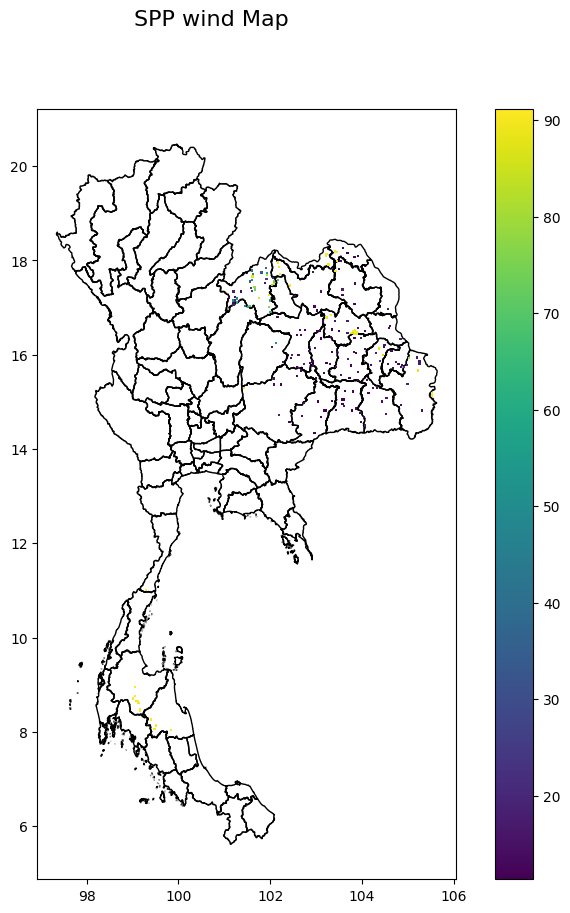

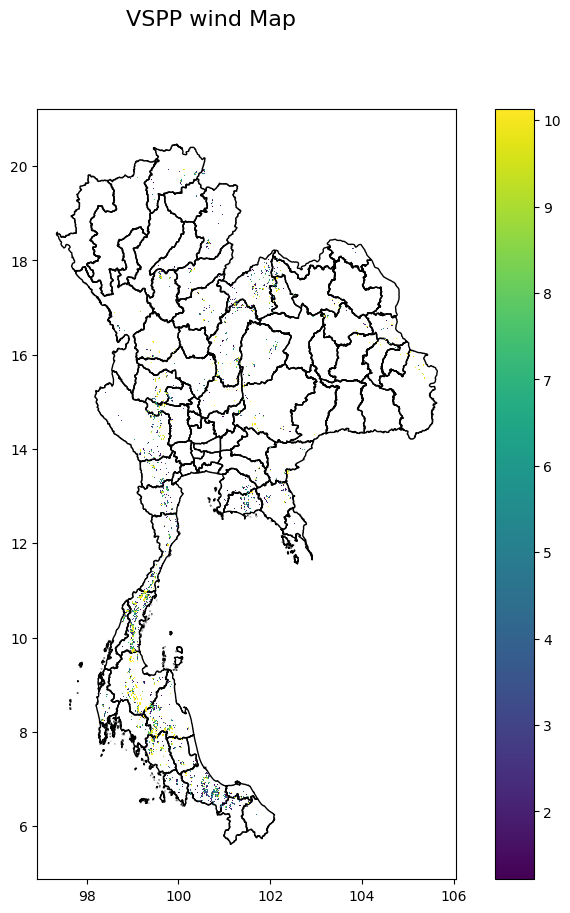

In [6]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}

print("total wind capacity = ", df_wind_spp['cap_SPP_wind'].sum() + df_wind_vspp['cap_VSPP_wind'].sum())
print("total SPP wind capacity = ", df_wind_spp['cap_SPP_wind'].sum())
print("total VSPP wind capacity = ", df_wind_vspp['cap_VSPP_wind'].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('SPP wind Map', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_wind_spp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_SPP_wind')
except:
    None
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('VSPP wind Map', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_wind_vspp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_VSPP_wind')
except:
    None

total solar capacity =  1165023.0353104458
total SPP solar capacity =  28491.749747272002
total VSPP solar capacity =  1136531.2855631737


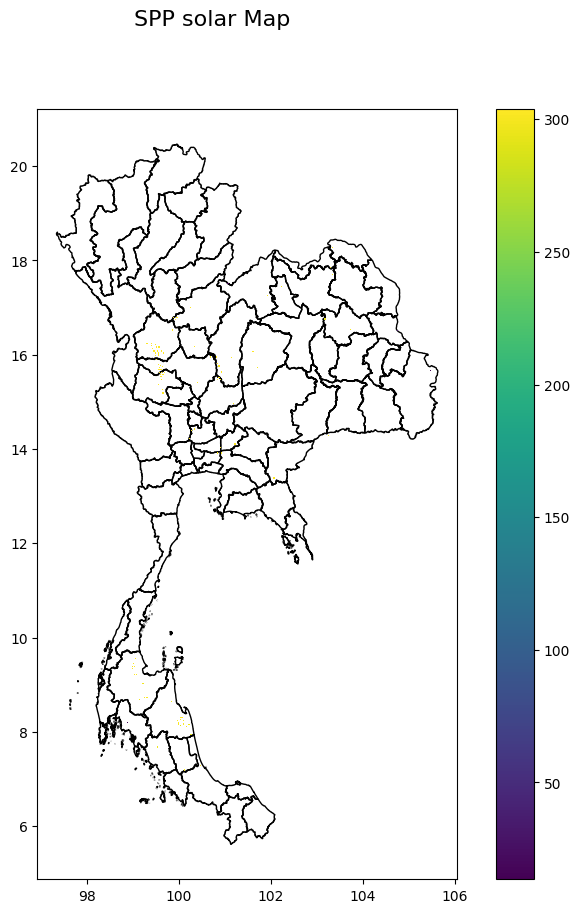

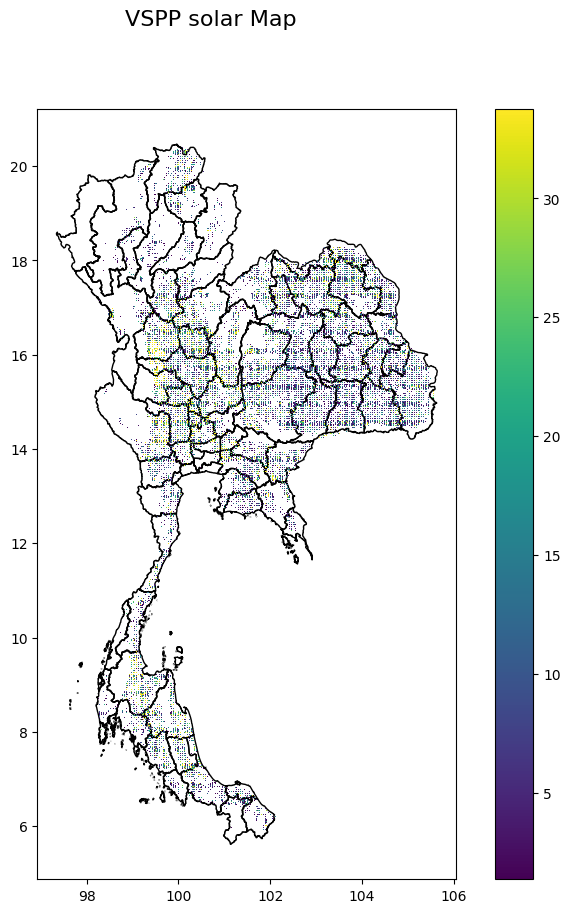

In [7]:
print("total solar capacity = ", df_solar_spp['cap_SPP_solar'].sum() + df_solar_vspp['cap_VSPP_solar'].sum())
print("total SPP solar capacity = ", df_solar_spp['cap_SPP_solar'].sum())
print("total VSPP solar capacity = ", df_solar_vspp['cap_VSPP_solar'].sum())

fig, ax = plt.subplots(figsize=(10,10))

fig.suptitle('SPP solar Map', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_solar_spp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_SPP_solar')
except:
    None

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('VSPP solar Map', fontsize=16)
try:
    thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df_solar_vspp.plot(ax = ax,legend=True,zorder = 1,column = 'cap_VSPP_solar')
except:
    None

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


total wind capacity =  1309.36501300334
total SPP wind capacity =  1040.0400085449
total VSPP wind capacity =  269.32500445844
total solar capacity =  24633.45079123408
total SPP solar capacity =  596.699981689
total VSPP solar capacity =  24036.750809545083


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


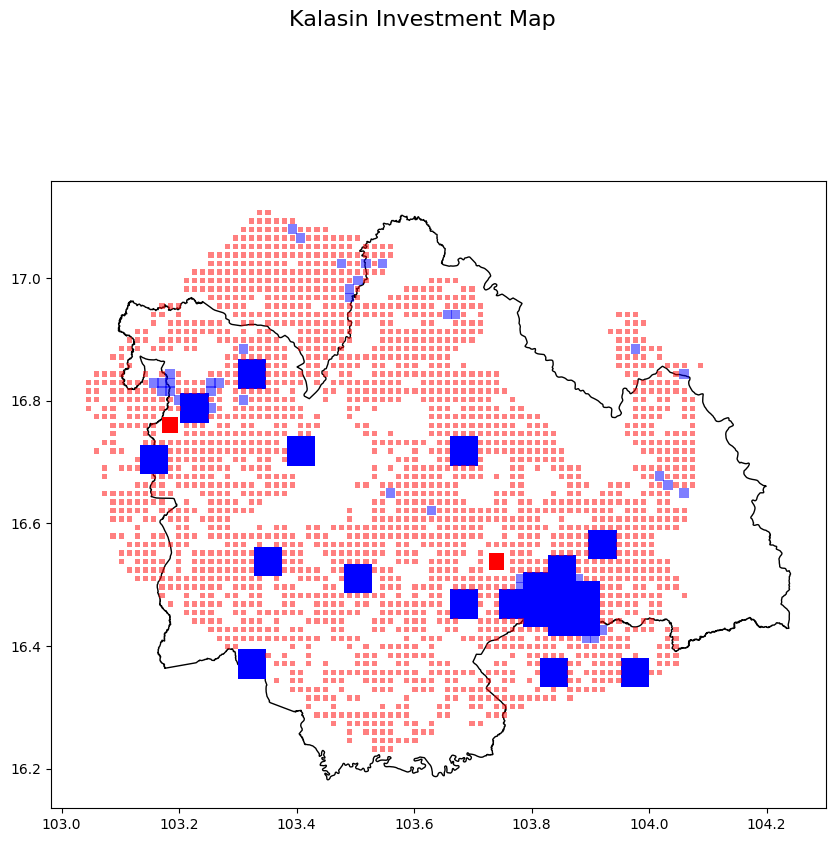

In [9]:
province = 'Kalasin'
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
specificarea = thailandmap.loc[thailandmap['ADM1_EN'] == province]
bound = specificarea.unary_union.bounds

print("total wind capacity = ", df_wind_spp['cap_SPP_wind'].loc[df_wind_spp['ADM1_EN'] == province].sum() + df_wind_vspp['cap_VSPP_wind'].loc[df_wind_vspp['ADM1_EN'] == province].sum())
print("total SPP wind capacity = ", df_wind_spp['cap_SPP_wind'].loc[df_wind_spp['ADM1_EN'] == province].sum())
print("total VSPP wind capacity = ", df_wind_vspp['cap_VSPP_wind'].loc[df_wind_vspp['ADM1_EN'] == province].sum())

print("total solar capacity = ", df_solar_spp['cap_SPP_solar'].loc[df_solar_spp['ADM1_EN'] == province].sum() + df_solar_vspp['cap_VSPP_solar'].loc[df_solar_vspp['ADM1_EN'] == province].sum())
print("total SPP solar capacity = ", df_solar_spp['cap_SPP_solar'].loc[df_solar_spp['ADM1_EN'] == province].sum())
print("total VSPP solar capacity = ", df_solar_vspp['cap_VSPP_solar'].loc[df_solar_vspp['ADM1_EN'] == province].sum())

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(province + ' Investment Map ', fontsize=16)
specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
try:
    df_wind_spp.loc[df_wind_spp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 1,column = 'cap_SPP_wind',color = 'blue')
except:
    None
try:
    df_wind_vspp.loc[df_wind_vspp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 2,column = 'cap_VSPP_wind',color = 'blue',alpha = 0.5)
except:
    None    
try:
    df_solar_spp.loc[df_solar_spp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 3,column = 'cap_SPP_solar',color = 'red')
except:
    None
try:
    df_solar_vspp.loc[df_solar_vspp['ADM1_EN'] == province].plot(ax = ax,legend=True,zorder = 4,column = 'cap_VSPP_solar',color = 'red',alpha = 0.5)
except:
    None